In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()


import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these (text, label) pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'There is only one use for a film such as Bulletproof: it reminds you just how bad bad can be. We often see films which we describe as "pretty awful" or "not much good", but then you come across a film like this and you can see that although all those other films aren\'t "good" they are no way as stinkingly bad as Bulletproof. This was a birthday gift from someone who spent less than two seconds rummaging thru\' the DVD bargain bin at our local superstore to fulfil an obligation (i.e. to give me a present). It could have been a serendipitous find but it wasn\'t: this is so utterly clich\xc3\xa9d, so badly written, so poorly directed, so badly acted that I\'m surprised everyone involved hasn\'t been arrested and sent down for 10 years. God, it\'s awful. I suspected as much from about 30 seconds in, but carried on because sometimes - sometimes - bad films are so bad they can be enjoyable. This isn\'t one of them. It is simply bad. I stopped watching after 45 minutes, and tomorr

Create the layer, and pass the dataset's text to the layer's .adapt method:



In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 48,   7,  61, ...,   0,   0,   0],
       [ 48,  24, 164, ...,   0,   0,   0],
       [  1,   1, 326, ...,   0,   0,   0]])

The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
The limited vocabulary size and lack of character-based fallback results in some unknown tokens

In [12]:
 for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'There is only one use for a film such as Bulletproof: it reminds you just how bad bad can be. We often see films which we describe as "pretty awful" or "not much good", but then you come across a film like this and you can see that although all those other films aren\'t "good" they are no way as stinkingly bad as Bulletproof. This was a birthday gift from someone who spent less than two seconds rummaging thru\' the DVD bargain bin at our local superstore to fulfil an obligation (i.e. to give me a present). It could have been a serendipitous find but it wasn\'t: this is so utterly clich\xc3\xa9d, so badly written, so poorly directed, so badly acted that I\'m surprised everyone involved hasn\'t been arrested and sent down for 10 years. God, it\'s awful. I suspected as much from about 30 seconds in, but carried on because sometimes - sometimes - bad films are so bad they can be enjoyable. This isn\'t one of them. It is simply bad. I stopped watching after 45 minutes, and tomo

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask

Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train the model

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.5167 - loss: 0.6820 - val_accuracy: 0.7823 - val_loss: 0.5149
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.8107 - loss: 0.4283 - val_accuracy: 0.8208 - val_loss: 0.3824
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 591s 2s/step - accuracy: 0.8438 - loss: 0.3528 - val_accuracy: 0.8589 - val_loss: 0.3342
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 592s 2s/step - accuracy: 0.8548 - loss: 0.3289 - val_accuracy: 0.8526 - val_loss: 0.3378
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.8614 - loss: 0.3192 - val_accuracy: 0.8417 - val_loss: 0.3341
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 591s 2s/step - accuracy: 0.8689 - loss: 0.3044 - val_accuracy: 0.8484 - val_loss: 0.3246
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.8677 - loss: 0.3062 - val_accuracy: 0.8573 - val_loss: 0.3220
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.8650 - loss: 0.3097 - val_accu

(0.0, 0.6548565417528153)

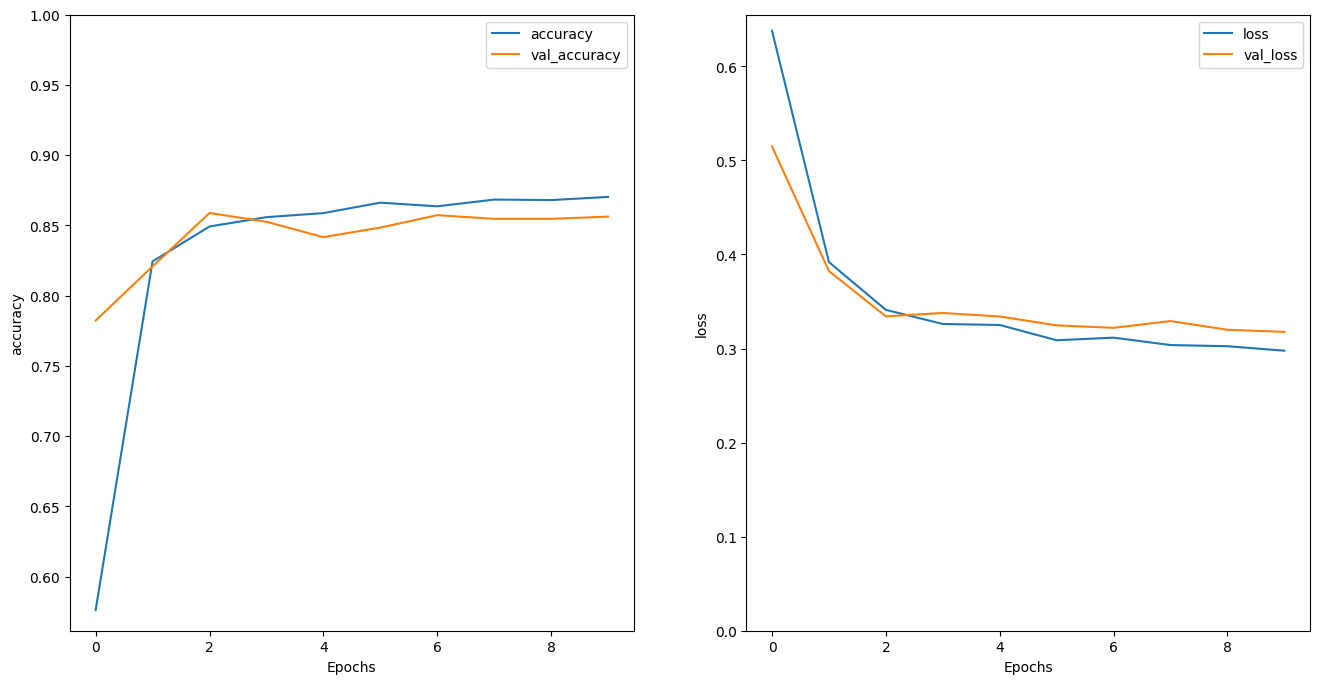

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.


In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

ValueError: Invalid dtype: str3328

Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])




history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)



test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)



# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1181s 3s/step - accuracy: 0.5225 - loss: 0.6746 - val_accuracy: 0.8240 - val_loss: 0.4149
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1148s 3s/step - accuracy: 0.8236 - loss: 0.4013 - val_accuracy: 0.8438 - val_loss: 0.3524
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1162s 3s/step - accuracy: 0.8497 - loss: 0.3456 - val_accuracy: 0.8448 - val_loss: 0.3354
Epoch 4/10
 39/391 ━━━━━━━━━━━━━━━━━━━━ 16:45 3s/step - accuracy: 0.8586 - loss: 0.3375